**References:** Chapter 17 of Geron's book. For 1-Dim plots, Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains a VAE with the instances of the normal digits in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digits in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated.

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

**Loading the MNIST data and forming arrays of the normal training data and the test data (normal and abnormal)**

In [4]:
nl1 = 4   # Normal digit(s)
nl2 = 2
abn1 = 8  # Abnormal digit(s)
abn2 = 8

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

normal_data = x_train[(y_train == nl1) | (y_train == nl2)]        # Normal training data (Normal digitss)
normal_labels = y_train[(y_train == nl1) | (y_train == nl2)]

test_data = x_test[(y_test == abn1) | (y_test == abn2) | (y_test == nl1) | (y_test == nl2)]    # Test data (both normal digits and the abnormal digit)
test_labels = y_test[(y_test == abn1) | (y_test == abn2) | (y_test == nl1) | (y_test == nl2)]

test_labels_T_F = np.where((test_labels == nl1) | (test_labels == nl2), True, False)
# Array of T and F, T where test digits are normal and F where test digits are abnormal

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
normal_data.shape, test_data.shape, test_labels.shape

((11800, 28, 28), (2988, 28, 28), (2988,))

In [6]:
normal_test_data = test_data[(test_labels == nl1) | (test_labels == nl2)]            # The normal digits in the test data
abnormal_test_data = test_data[(test_labels == abn1) | (test_labels == abn2)]        # The abnormal digits in the test data
normal_test_labels = test_labels[(test_labels == nl1) | (test_labels == nl2)]        # Their labels
abnormal_test_labels = test_labels[(test_labels == abn1) | (test_labels == abn2)]    # Their labels

In [7]:
normal_test_data.shape, abnormal_test_data.shape 

((2014, 28, 28), (974, 28, 28))

In [8]:
def show_reconstructions(model, images=test_data, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [9]:
K = keras.backend
# def rounded_accuracy(y_true, y_pred):
  #  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
# For details please see Geron's book. Uses the reparametrization trick to do stochastic 
# sampling from the MVN distribution, while allowing the 2 parallel layers containing the 
# means and stds of the MVN distribution for each dimension to be trained via 
# backpropogation of the error signal.
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [11]:
# For details please see Geron's book. 
codings_size = 16   # The number of dimensions of the MVN distribution in the sampling layer

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(256, activation="selu")(z)
z = keras.layers.Dense(128, activation="selu")(z)
z = keras.layers.Dense(64, activation="selu")(z)

# Parallel layers at the end of the encoder for means 
# and standard deviations of the Multivariate Normal (MVN) distribution 
# in the dimensions of the coding size (here 32). 
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)

# Sampling layer at the end of the encoder
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(64, activation="selu")(decoder_inputs)
x = keras.layers.Dense(128, activation="selu")(x)
x = keras.layers.Dense(256, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# The latent loss function
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

# Add the latent loss to the reconstruction loss
variational_ae.add_loss(K.mean(latent_loss) / 784.)

# For the reconstruction loss binary cross-entropy loss is used. 
# For details please see Chapter 17 of Geron's book (Stacked AE and VAE sections) 
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")
history = variational_ae.fit(normal_data, normal_data, epochs=100, batch_size=16,
                             validation_data=(normal_test_data, normal_test_data), shuffle=True)

Epoch 1/100
738/738 [==============================] - 21s 15ms/step - loss: 0.2174 - val_loss: 0.1883
Epoch 2/100
738/738 [==============================] - 7s 9ms/step - loss: 0.1753 - val_loss: 0.1685
Epoch 3/100
738/738 [==============================] - 7s 9ms/step - loss: 0.1639 - val_loss: 0.1577
Epoch 4/100
738/738 [==============================] - 7s 10ms/step - loss: 0.1584 - val_loss: 0.1666
Epoch 5/100
738/738 [==============================] - 7s 10ms/step - loss: 0.1549 - val_loss: 0.1522
Epoch 6/100
738/738 [==============================] - 7s 10ms/step - loss: 0.1527 - val_loss: 0.1531
Epoch 7/100
738/738 [==============================] - 7s 10ms/step - loss: 0.1508 - val_loss: 0.1535
Epoch 8/100
738/738 [==============================] - 7s 10ms/step - loss: 0.1495 - val_loss: 0.1513
Epoch 9/100
738/738 [==============================] - 7s 10ms/step - loss: 0.1482 - val_loss: 0.1497
Epoch 10/100
738/738 [==============================] - 7s 9ms/step - loss: 0.1473 

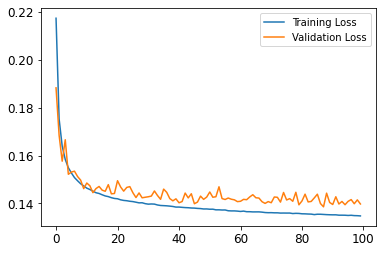

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

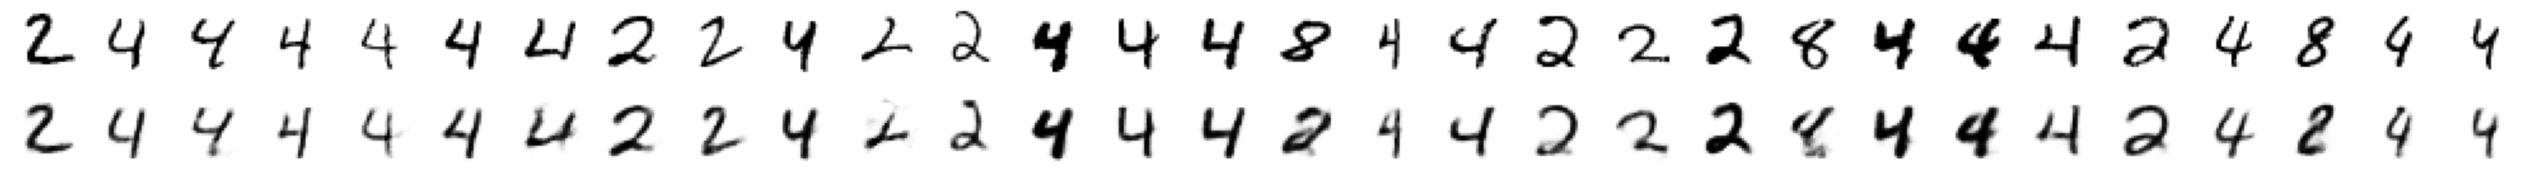

In [13]:
show_reconstructions(variational_ae, test_data, 30)
plt.show()

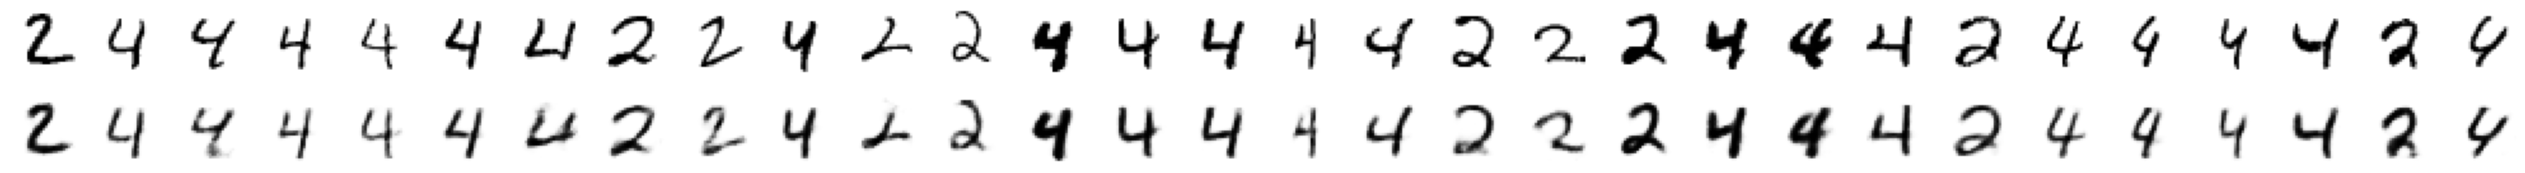

In [14]:
show_reconstructions(variational_ae, normal_test_data, 30)
plt.show()

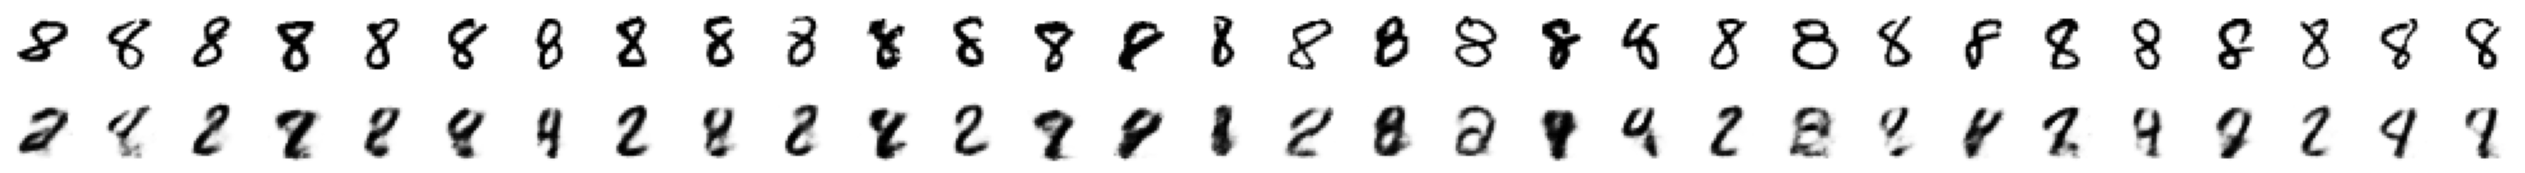

In [15]:
show_reconstructions(variational_ae, abnormal_test_data, 30)
plt.show()

In [16]:
reconstructions_nl_test = variational_ae.predict(normal_test_data)

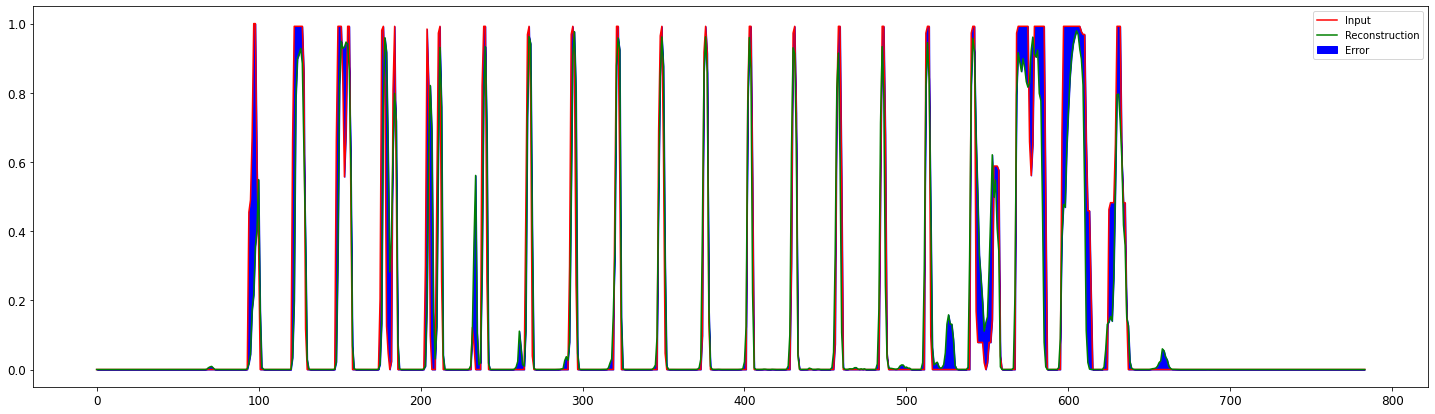

In [17]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_nl_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_nl_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [18]:
reconstructions_abn_test = variational_ae.predict(abnormal_test_data)

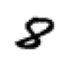

In [19]:
plt.figure(figsize=(1,1))
plt.imshow(abnormal_test_data[0], cmap="binary")
plt.axis('off')
plt.show()

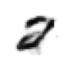

In [20]:
plt.figure(figsize=(1,1))
plt.imshow(reconstructions_abn_test[0], cmap="binary")
plt.axis('off')
plt.show()

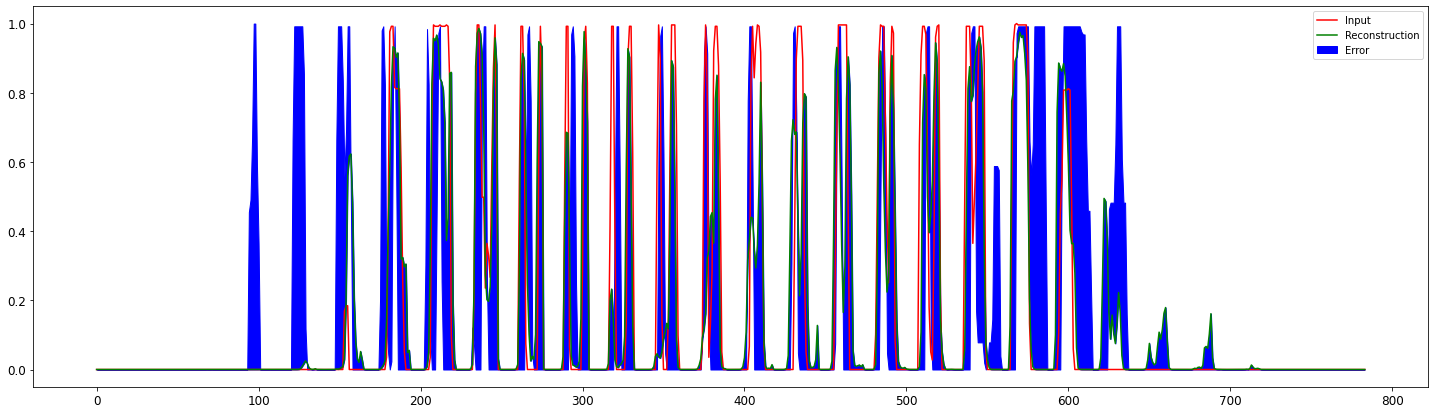

In [21]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_abn_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_abn_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**Distribution of the reconstruction losses of the normal training data**

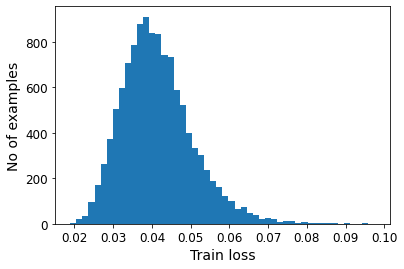

In [22]:
reconstructions_nl_data = variational_ae.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions_nl_data.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [23]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.041450977
Std:  0.009285277


In [24]:
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold1: ", threshold1)

Threshold1:  0.06466416921466589


**Distribution of the reconstruction losses of the abnormal test data**

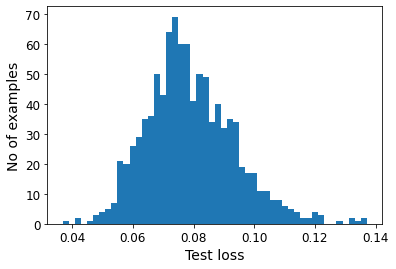

In [25]:
abn_test_loss = tf.keras.losses.mae(reconstructions_abn_test.reshape(-1,784), abnormal_test_data.reshape(-1,784))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [26]:
# threshold2 = np.mean(abn_test_loss) - np.std(abn_test_loss)
# print("Threshold2: ", threshold2)

In [27]:
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.079052374, 0.014618977)

**Threshold will be threshold1 = mean + std of the distribution of the reconstruction losses of the normal training data**

In [28]:
threshold = threshold1

**Calculation of the confusion matrix**

In [29]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [30]:
preds = predict(variational_ae, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             923   2065
 label: F   [[833   141]    974
        T    [90   1924]]   2014
Accuracy = 0.9226907630522089
Precision = 0.9317191283292978
Recall = 0.9553128103277061


In [31]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 833  141]
 [  90 1924]]


**Distribution of the reconstruction losses of the test data (normal and abnormal)**

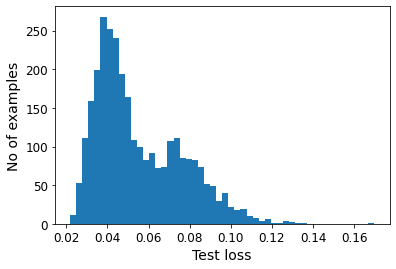

In [32]:
reconstructions_test_data = variational_ae.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions_test_data.reshape(-1,784), test_data.reshape(-1,784))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [33]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

**Extra Info**

Giving the VAE codings (please see book) (Just informative, not the goal here)

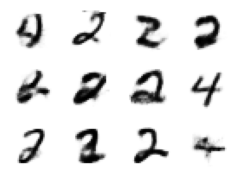

In [34]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
# save_fig("vae_generated_images_plot", tight_layout=False)

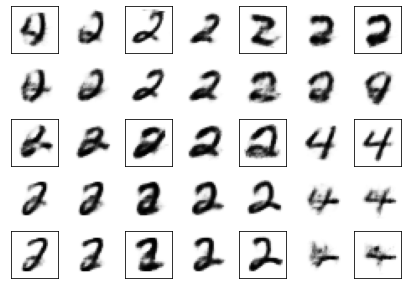

In [35]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
# save_fig("semantic_interpolation_plot", tight_layout=False)